## https://github.com/fehiepsi/web-traffic-time-series-forecasting/blob/master/executable/model_rnn.ipynb

My model is a 3-layer LSTM model with skip connection between layers (like DenseNet). I found that RMSprop (with clipping gradients) is more stable than Adam. Recent research papers show that SGD gives the best results. However, due to limited time, I have not tried to optimize the model using SGD yet.

To train the model, I skipped the first three months and take the loss of (randomly selected) 385 days to do back-propagation. With `batch_size=256` and 6 epochs, it took me an hour to train the model (quite fast to obtain a reasonable result).

### setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [2]:
import os
import argparse
import pickle
import time

import numpy as np; np.seterr(invalid='ignore')
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from tqdm import tqdm_notebook as tqdm

In [12]:
parser = {
    'data_path': '../data/google_wtts/backup/',
    'train_file': 'train.csv',
    'key_file': 'key.csv',
    'intermediate_path': '../data/google_wtts/intermediate/',
    'train_len': 385,
    'train_skip': 91,
    'val_len': 60,
    'offset': 803,
    'batch_size': 256 + 128 + 64,
    'hidden_size': 256,
    'log_every': 10,
    'read_from_file': False,
    'train': True,
    'model_name': '',
    'forecast': True,
    'cuda': True,
    'seed': 20170913,
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

args.intermediate_path = os.path.join(args.intermediate_path, str(args.seed))

In [13]:
torch.cuda.device_count()

2

### model

In [14]:
class DenseLSTMForecast(nn.Module):
    def __init__(self, hidden_size):
        super(DenseLSTMForecast, self).__init__()
        self.lstm1 = nn.LSTMCell(1, hidden_size)
        self.lstm2 = nn.LSTMCell(hidden_size+1, hidden_size)
        self.lstm3 = nn.LSTMCell(2*hidden_size+1, hidden_size)
        self.linear = nn.Linear(3*hidden_size+1, 1)
        self.hidden_size = hidden_size

    def forward(self, x, future=0):
        o = []
        tt = torch.cuda if args.cuda else torch
        h1_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c1_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        h2_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c2_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        h3_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c3_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        
        for x_t in x.chunk(x.size(1), dim=1):
            x_t = x_t.squeeze(dim=1)
            h1_t, c1_t = self.lstm1(x_t, (h1_t, c1_t))
            h1d_t = torch.cat([x_t, h1_t], dim=1)
            h2_t, c2_t = self.lstm2(h1d_t, (h2_t, c2_t))
            h2d_t = torch.cat([x_t, h1_t, h2_t], dim=1)
            h3_t, c3_t = self.lstm3(h2d_t, (h3_t, c3_t))
            h3d_t = torch.cat([x_t, h1_t, h2_t, h3_t], dim=1)
            o_t = self.linear(h3d_t)
            o.append(o_t)

            
        for i in range(future):
            h1_t, c1_t = self.lstm1(o_t, (h1_t, c1_t))
            h1d_t = torch.cat([o_t, h1_t], dim=1)
            h2_t, c2_t = self.lstm2(h1d_t, (h2_t, c2_t))
            h2d_t = torch.cat([o_t, h1_t, h2_t], dim=1)
            h3_t, c3_t = self.lstm3(h2d_t, (h3_t, c3_t))
            h3d_t = torch.cat([o_t, h1_t, h2_t, h3_t], dim=1)
            o_t = self.linear(h3d_t)
            o.append(o_t)

        return torch.stack(o, dim=1)

### utils

In [15]:
def smape(y_pred, y_true):
    y_pred = np.around(y_pred)
    denominator = y_true + y_pred
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0
    return 200 * np.nanmean(diff)

In [16]:
def get_data(days_to_leave=60):
    raw_data_file = os.path.join(args.intermediate_path, 'raw_data.pkl')
    scaled_data_file = os.path.join(args.intermediate_path,
                                    'scaled_data.pkl')
    scaler_file = os.path.join(args.intermediate_path, 'scaler.pkl')
    
    if not args.read_from_file:
        data_df = pd.read_csv(os.path.join(args.data_path, args.train_file),
                              index_col='Page')
        raw_data = data_df.values.copy()
        data_df = data_df.fillna(method='ffill', axis=1).fillna(
            method='bfill', axis=1)
        test_data = data_df.values[:, -days_to_leave:]
        
        data = np.nan_to_num(data_df.values[:, :-days_to_leave].astype('float32'))
        data = np.log1p(data)
        
        scaler = StandardScaler()
        scaler.fit(np.swapaxes(data, 0, 1))
        scaled_data = scaler.transform(np.swapaxes(data, 0, 1))
        scaled_data = np.swapaxes(scaled_data, 0, 1)
        
        with open(raw_data_file, 'wb') as f:
            pickle.dump(raw_data, f)
        with open(scaled_data_file, 'wb') as f:
            pickle.dump(scaled_data, f)
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
    else:
        with open(raw_data_file, 'rb') as f:
            raw_data = pickle.load(f)
        with open(scaled_data_file, 'rb') as f:
            scaled_data = pickle.load(f)
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
    return raw_data, scaled_data, scaler, test_data

In [17]:
def train(raw_data, scaled_data, test_data,
          scaler, model,
          criterion, loss_for_val,
          optimizer):
    p = np.random.permutation(scaled_data.shape[0])
    inverse_p = np.argsort(p)
    
    input_tensor = torch.from_numpy(scaled_data[p, :(args.offset-1)]).unsqueeze(2)
    target_tensor = torch.from_numpy(scaled_data[p, 1:args.offset]).unsqueeze(2)
    test_tensor = torch.from_numpy(test_data[p, :]).unsqueeze(2)
    mean = torch.from_numpy(scaler.mean_[p])
    scale = torch.from_numpy(scaler.scale_[p])
    
    
    dataset = TensorDataset(input_tensor, target_tensor, test_tensor, mean, scale)
    data_loader = DataLoader(dataset, args.batch_size)
    
    print("Finished loading data")
    
    train_loss = 0
    
    init_time = time.time()
    for i, (inputt, target, test, mean, scale) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if args.cuda:
            inputt = inputt.cuda()
            target = target.cuda()
        inputt = Variable(inputt)
        target = Variable(target)
        
        output = model(inputt)
        pos = np.random.randint(args.train_skip, inputt.size(1)-args.train_len+1)
        loss = criterion(output[:, pos:pos+args.train_len],
                         target[:, pos:pos+args.train_len])
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), 3, 'inf')
        optimizer.step()
        train_loss += loss.data[0] * inputt.size(0)
        
        
        if i % args.log_every == 0:
            output = model(inputt, args.val_len)
            y_pred = output.data.squeeze(2).cpu().numpy()[:, -args.val_len:]
            
            y_pred = np.round(
                np.clip(
                    np.expm1(y_pred * scale.reshape(-1, 1) + mean.reshape(-1, 1)), 0, None
                ), 0
            )
            
            y_true = test.squeeze(2).cpu().numpy()
            val_loss = loss_for_val(y_pred, y_true)
            print("   % Time: {:4.0f}s | Batch: {:4} | "
                  "Train loss: {:.4f}  | SMAPE: {:4f}".format(
                      time.time()-init_time, i+1, loss.data[0], val_loss))
        
#    val_output_all = np.concatenate(val_output_list, axis=0)[inverse_p]
#    prediction = np.swapaxes(scaler.inverse_transform(
#           np.swapaxes(val_output_all, 0, 1)), 0, 1)
#    prediction = np.clip(np.exp(prediction)-1, 0, None)
#    var_target = raw_data[:, args.offset:args.offset+args.val_len]
    
    train_loss /= scaled_data.shape[0]
#    val_loss = smape(prediction, var_target)
    val_loss = 0
    print("="*10)
    print("   % Epoch: {} | Time: {:4.0f}s | "
          "Train loss: {:.4f} | Val loss: {:.4f}"
          .format(epoch, time.time()-init_time, train_loss, val_loss))
    print("="*10)
    return val_loss

In [18]:
def save_model(model, epoch, loss):
    model_file = os.path.join(args.intermediate_path,
                              "model_{}_epoch{}_loss{:.4f}.pth"
                              .format(args.seed, epoch, loss))
    torch.save(model.state_dict(), os.path.join(model_file))

### prepare

In [19]:
raw_data, scaled_data, scaler, test_data = get_data()

In [21]:
raw_data.shape

(145063, 803)

In [13]:
model = DenseLSTMForecast(args.hidden_size)
if args.cuda:
    model.cuda()
criterion = nn.L1Loss()

In [14]:
model = nn.DataParallel(model, device_ids=[0, 1])

In [31]:
model.load_state_dict(torch.load(args.intermediate_path+"/model_20170913_epoch6_loss0.0000.pth"))

In [32]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[2, 4])

### train

In [20]:
if args.train:
    for epoch in range(1, 7):
        scheduler.step()
        print("=> EPOCH {} with lr {}".format(epoch, scheduler.get_lr()))
        val_loss = train(raw_data, scaled_data, test_data,
                         scaler, model,
                         criterion, smape,
                         optimizer)
        save_model(model, epoch, val_loss)
else:
    model_file = os.path.join(args.intermediate_path, args.model_name)
    model.load_state_dict(torch.load(model_file))

=> EPOCH 1 with lr [0.001]
Finished loading data


/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


KeyboardInterrupt: 

In [33]:
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
scheduler = MultiStepLR(optimizer, milestones=[2, 4])

In [34]:
if args.train:
    for epoch in range(7, 8):
        scheduler.step()
        print("=> EPOCH {} with lr {}".format(epoch, scheduler.get_lr()))
        val_loss = train(raw_data, scaled_data, test_data,
                         scaler, model,
                         criterion, smape,
                         optimizer)
        save_model(model, epoch, val_loss)
else:
    model_file = os.path.join(args.intermediate_path, args.model_name)
    model.load_state_dict(torch.load(model_file))

=> EPOCH 7 with lr [0.0001]
Finished loading data


/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


   % Time:    4s | Batch:    1 | Train loss: 0.3873  | SMAPE: 51.108246
   % Time:   44s | Batch:   11 | Train loss: 0.3895  | SMAPE: 42.651664
   % Time:   71s | Batch:   21 | Train loss: 0.4096  | SMAPE: 39.861239
   % Time:   99s | Batch:   31 | Train loss: 0.3963  | SMAPE: 41.680056
   % Time:  126s | Batch:   41 | Train loss: 0.4086  | SMAPE: 40.341375
   % Time:  154s | Batch:   51 | Train loss: 0.3913  | SMAPE: 39.400772
   % Time:  181s | Batch:   61 | Train loss: 0.4021  | SMAPE: 38.060352
   % Time:  209s | Batch:   71 | Train loss: 0.3995  | SMAPE: 40.779301
   % Time:  236s | Batch:   81 | Train loss: 0.3921  | SMAPE: 41.333492
   % Time:  264s | Batch:   91 | Train loss: 0.4105  | SMAPE: 40.380058
   % Time:  291s | Batch:  101 | Train loss: 0.3931  | SMAPE: 38.725652
   % Time:  319s | Batch:  111 | Train loss: 0.3934  | SMAPE: 38.478871
   % Time:  346s | Batch:  121 | Train loss: 0.3950  | SMAPE: 40.011794
   % Time:  374s | Batch:  131 | Train loss: 0.3900  | SMAPE: 37

### test

In [36]:
def forecast(raw_data, scaled_data, scaler, model):
    input_tensor = torch.from_numpy(scaled_data[:, :args.offset]).unsqueeze(2)
    target_tensor = torch.zeros(input_tensor.size(0))
    dataset = torch.utils.data.TensorDataset(input_tensor, target_tensor)
    data_loader = DataLoader(dataset, 256+128)
    
    output_list = []
    for i, (inputt, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if args.cuda:
            inputt = inputt.cuda()
        inputt = Variable(inputt)
        output = model(inputt, args.val_len)
        output_list.append(output.data.squeeze(2).cpu().numpy()
                           [:, -args.val_len:])
        
    output_all = np.concatenate(output_list, axis=0)
    prediction = np.swapaxes(scaler.inverse_transform(
            np.swapaxes(output_all, 0, 1)), 0, 1)

    prediction = np.clip(np.exp(prediction) - 1, 0, None)
    
    return prediction

In [37]:
prediction = []
if args.forecast:
    prediction = forecast(raw_data, scaled_data, scaler, model)
#    print("SMAPE: {}".format(smape(prediction, raw_data[:,
#        args.offset:args.offset+args.val_len])))
    with open(os.path.join(args.intermediate_path,
                           "pred_rnn.pkl"), "wb") as f:
        pickle.dump(prediction, f)
        
    

In [39]:
import utils

In [43]:
prediction.shape

(145063, 60)

In [42]:
utils.SMAPE_score(test_data, np.round(prediction, 0))

SMAPE:  39.40128358123823


array([ 32.65310267,  35.73949424,  53.77660386, ...,  90.77147321,
        77.95369409, 138.06800656])

In [44]:
!mkdir models/lstm

In [45]:
!ls models

fibonachi_medians  median_daily_last_7_weeks  nanmedian_on_last_16
info.csv	   nanmean_last_50	      scores.csv
last_elem	   nanmean_on_last_4	      test
lstm		   nanmedian_last_50	      weighted_median_092_decay


In [46]:
np.save("models/lstm/predictions.npy", prediction)

# Plot prediction

In [41]:
prediction = np.load("../data/google_wtts/models/lstm/predictions.npy")

train, test, info, index = utils.ReadData("debug3")

val = test.values
train_for_val = train.values

In [42]:
# 43 -- 4388
i = 43
j = 4388
row_train = np.log1p(train_for_val[i])
row_val = np.log1p(val[i])

In [43]:
import utils
import importlib
importlib.reload(utils)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams["font.size"] = 14

In [48]:
def plot_prediction(row_train, row_val, preds, title, lags=100):
    plt.plot(np.concatenate((row_train[-lags:], row_val)), label='validation')
    plt.vlines(lags, row_val.min(), row_val.max(), linestyles='--')
    plt.plot(row_train[-lags:], label='train')
    plt.plot(np.arange(100, 160), preds, label='prediction')
    plt.xlabel('days')
    plt.ylabel('log')
    plt.legend()
    plt.title(title)
    plt.show()

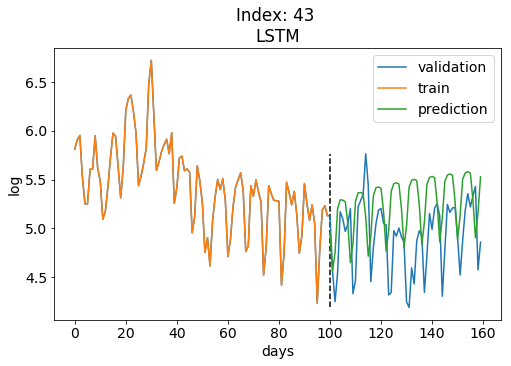

In [50]:
plot_prediction(row_train, row_val, 
                np.log1p(prediction[j]), 
                'Index: %i \nLSTM' % i)

In [35]:
index.iloc[43]

0    4388
Name: 43, dtype: int64